In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
from matplotlib.ticker import StrMethodFormatter, FuncFormatter, MaxNLocator

pd.options.display.float_format = '{:,.2f}'.format # formatação com duas casas decimais

In [7]:
# Conexão ao banco de dados

dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()


cursor = conn.cursor()

sql_amostra =   """
                SELECT *
                FROM boletins
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df = pd.read_sql(sql_amostra, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df.head()

id cod_cidade        data  testes_realizados  novos_testes  \
0   1       0001  17/04/2020                  0             0   
1   2       0001  18/04/2020                  0             0   
2   3       0001  19/04/2020                  0             0   
3   4       0001  20/04/2020                  0             0   
4   5       0001  21/04/2020                  0             0   

   casos_confirmados  novos_confirmados  z_centro  z_centrosul  z_leste  ...  \
0                  8                  0         0            0        0  ...   
1                 10                  2         0            0        0  ...   
2                 10                  0         0            0        0  ...   
3                 10                  0         0            0        0  ...   
4                 10                  0         0            0        0  ...   

   suspeitos_ala  suspeitos_uti  obitos_investigacao  uti_covid  \
0              1              0                    1          0   
1              2              1                    1          0   
2              2              1                    1          0   
3              2              2                    1          0   
4              3              2                    1          0   

   uti_covid_oc_conf  uti_covid_oc_susp  eventos         atualizacao  \
0                  0                  0     None 2020-05-13 18:08:06   
1                  0                  0     None 2020-05-13 18:08:06   
2                  0                  0     None 2020-05-13 18:08:06   
3                  0                  0     None 2020-05-13 18:08:06   
4                  0                  0     None 2020-05-13 18:08:06   

   populacao  vacinados  
0     167397          0  
1     167397          0  
2     167397          0  
3     167397          0  
4     167397          0  

[5 rows x 40 columns]

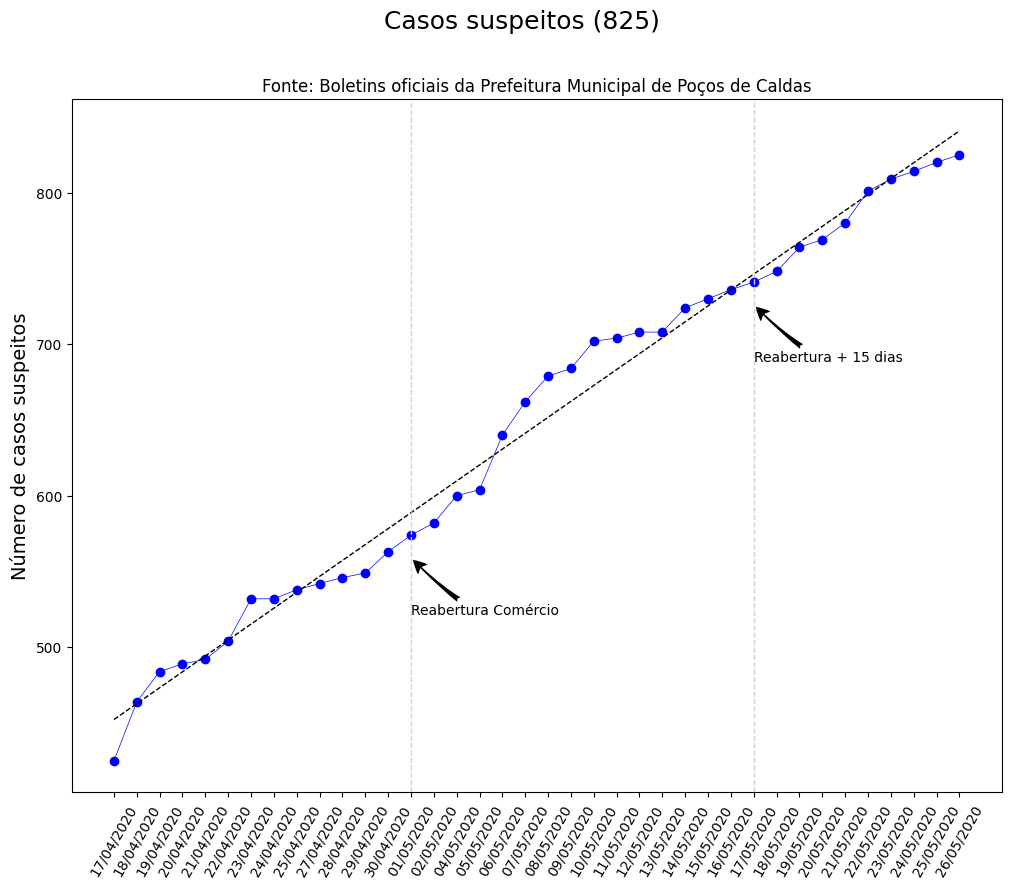

In [8]:
sql_amostra =   """
                SELECT *
                FROM boletins
                WHERE casos_suspeitos > 0
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df = pd.read_sql(sql_amostra, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_suspeitos = df.copy()

fig, ax = plt.subplots(figsize=(12, 9))

plt.xticks(df_suspeitos.index, df_suspeitos["data"].values, rotation=60)

x = df_suspeitos.reset_index()['index']
y = df_suspeitos['casos_suspeitos']
ax.scatter(x, y, color='blue')

ax.plot(y, color='blue', linewidth=0.5)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color="k", linewidth=1)

n_suspeitos = str(max(df_suspeitos['casos_suspeitos']))

plt.suptitle('Casos suspeitos (' + n_suspeitos + ')', fontsize=18)
plt.title('Fonte: Boletins oficiais da Prefeitura Municipal de Poços de Caldas', fontsize=12)

plt.ylabel('Número de casos suspeitos', fontsize=14)

for i, txt in enumerate(df_suspeitos['eventos']):
    if (txt != None):
        plt.annotate(txt, xy=(x[i],y[i]-15), xytext=(x[i],y[i]-50), 
                     arrowprops=dict(arrowstyle="fancy, head_width=1, head_length=1",
                            fc="0", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-45"), fontsize=10, va='center')
    
evento = df_suspeitos[df_suspeitos['eventos'].notnull()].index

xposition = evento

for xc in xposition:
    plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=1)

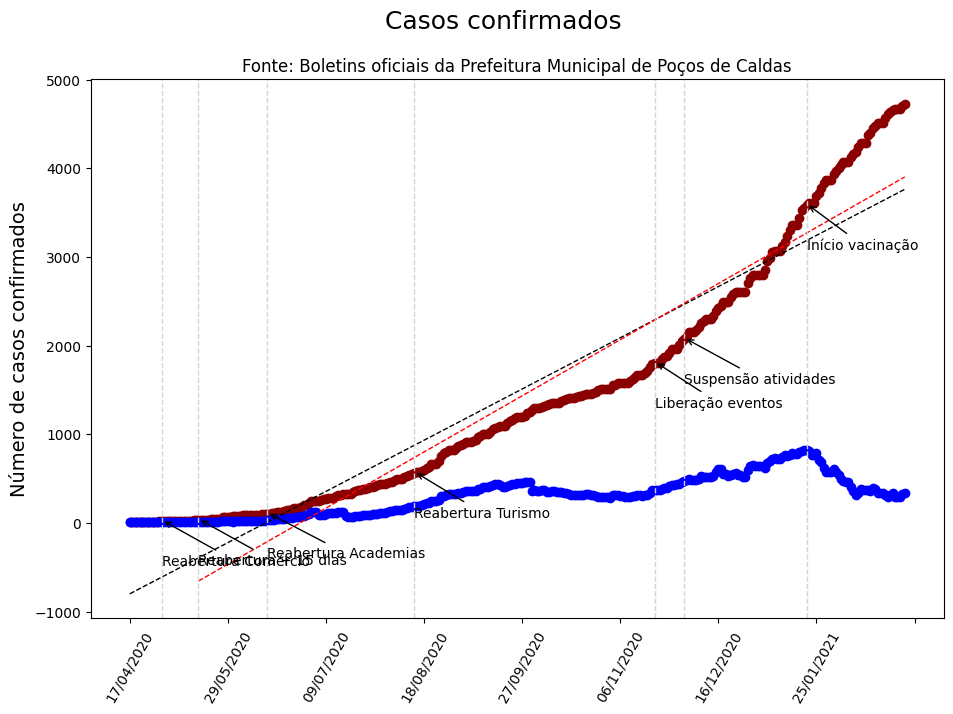

In [9]:
from matplotlib.dates import DateFormatter
import numpy as np

sql_amostra =   """
                SELECT id, data, casos_confirmados, (casos_confirmados - recuperados) as ativos, eventos
                FROM boletins
                ORDER by data ASC
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df = pd.read_sql(sql_amostra, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_confirmados = df.copy()

fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))

plt.xticks(df_confirmados.index, df_confirmados["data"].values, rotation=60)

x = df_confirmados.reset_index()['index']
y = df_confirmados['casos_confirmados']

ax.scatter(x, y, color='darkred')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x.values,p(x),"r--", color="k", linewidth=1)

filtro = (df_confirmados['id'] >= 29)

df_filtrado = df_confirmados.loc[filtro]

x2 = df_filtrado.reset_index()['index']
y2 = df_filtrado['casos_confirmados']

z2 = np.polyfit(x2, y2, 1)
p = np.poly1d(z2)
plt.plot(x2.values,p(x2),"r--", color="red", linewidth=1)

x3 = df_confirmados.reset_index()['index']
y3 = df_confirmados['ativos']

ax.scatter(x3, y3, color='blue')


plt.suptitle('Casos confirmados', fontsize=18)
plt.title('Fonte: Boletins oficiais da Prefeitura Municipal de Poços de Caldas', fontsize=12)

plt.ylabel('Número de casos confirmados', fontsize=14)

labels = list(df_confirmados['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


for i, txt in enumerate(df_confirmados['eventos']):
    if (txt != None):
        plt.annotate(txt, xy=(x[i],y[i]+15), xytext=(x[i],y[i]-450), arrowprops={'arrowstyle': '->'}, va='center')
    

evento = df_confirmados[df_confirmados['eventos'].notnull()].index

xposition = evento

for xc in xposition:
    plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=1)


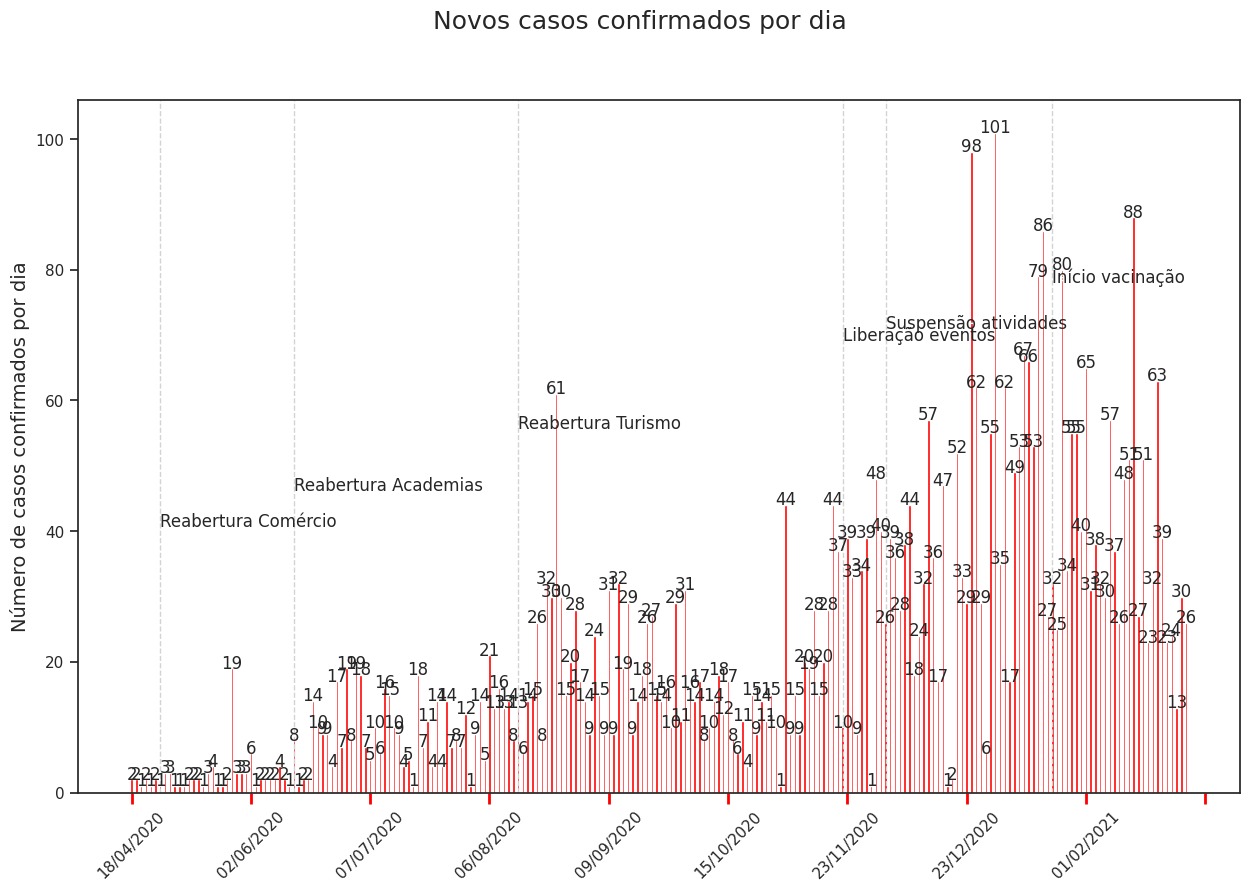

In [10]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1, rc={"grid.linewidth": 0.6})
flatui = ["#9b59b6","#3498db","#95a5a6","#e74c3c","#34495e","#2ecc71"]
sns.set_palette(flatui)

sns.set()
sns.set_style("whitegrid") 
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid") 

sql_amostra =   """
                SELECT data, novos_confirmados, eventos
                FROM boletins
                WHERE novos_confirmados > 0
                ORDER BY data asc
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df_novos = pd.read_sql(sql_amostra, conn)

df_novos['data'] = pd.to_datetime(df_novos['data'], format='%Y-%m-%d')
df_novos["data"] = df_novos["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

x = df_novos.reset_index()['index']

fig, ax = plt.subplots(figsize=(15, 9))

width = 0.5

ax.bar(x, df_novos['novos_confirmados'], width, color='red')

ax.tick_params('x', length=8, width=2, color='red',  which='major', direction='out')

plt.xticks(df_novos.index, df_novos["data"].values, rotation=45)

plt.suptitle('Novos casos confirmados por dia', fontsize=18)


plt.ylabel('Número de casos confirmados por dia', fontsize=14)

labels = list(df_novos['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

a = 40

for i, txt in enumerate(df_novos['eventos']):
    a = a + 0.2
    if (txt != None):
        plt.annotate(txt, xy=(x[i],a), xytext=(x[i],a), arrowprops={'arrowstyle': '->'}, va='center')
    
    
for i, valor in enumerate(df_novos['novos_confirmados']):
    plt.annotate(valor, (x[i],df_novos['novos_confirmados'].values[i]+0.02), ha='center')

evento = df_novos[df_novos['eventos'].notnull()].index

xposition = evento

for xc in xposition:
    plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=1)

plt.show()

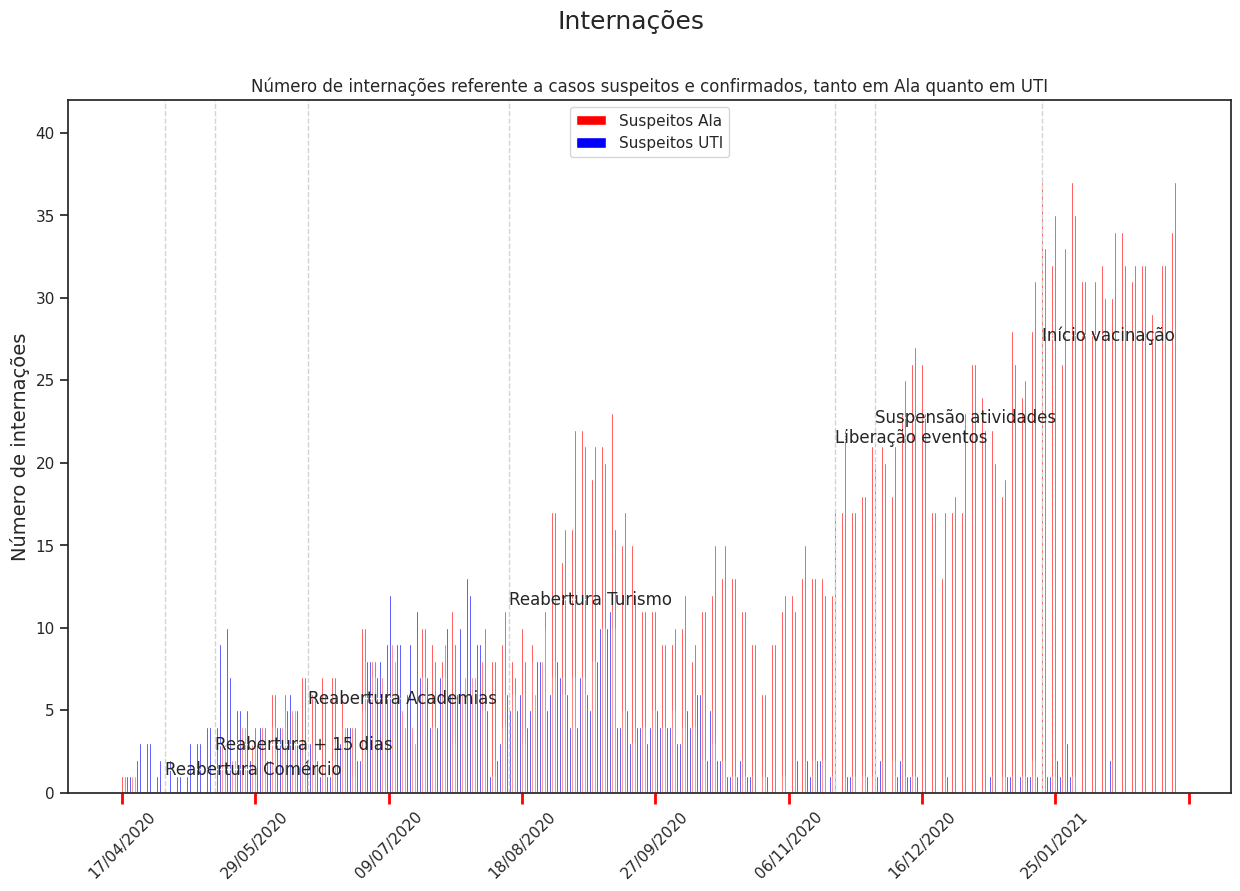

In [11]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1, rc={"grid.linewidth": 0.6})
flatui = ["#9b59b6","#3498db","#95a5a6","#e74c3c","#34495e","#2ecc71"]
sns.set_palette(flatui)

sns.set()
sns.set_style("whitegrid") 
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid") 

sql_amostra =   """
                SELECT data, suspeitos_ala, suspeitos_uti, confirmados_ala, confirmados_uti, eventos
                FROM boletins
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df_internacoes = pd.read_sql(sql_amostra, conn)

df_internacoes['data'] = pd.to_datetime(df_internacoes['data'], format='%Y-%m-%d')
df_internacoes["data"] = df_internacoes["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

x = df_internacoes.reset_index()['index']

fig, ax = plt.subplots(figsize=(15, 9))

width = 0.5

ax.bar(x, df_internacoes['confirmados_uti'], width, color='red')
ax.bar(x+width, df_internacoes['suspeitos_uti'], width, color='blue')

ax.tick_params('x', length=8, width=2, color='red',  which='major', direction='out')

plt.legend(["Suspeitos Ala", "Suspeitos UTI",  "Confirmados Ala", "Confirmados UTI"])

plt.xticks(df_internacoes.index, df_internacoes["data"].values, rotation=45)

plt.suptitle('Internações', fontsize=18)
plt.title('Número de internações referente a casos suspeitos e confirmados, tanto em Ala quanto em UTI', fontsize=12)

plt.ylabel('Número de internações', fontsize=14)

labels = list(df_internacoes['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

a = 0

for i, txt in enumerate(df_internacoes['eventos']):
    a = a + 0.1
    if (txt != None):
        plt.annotate(txt, xy=(x[i],a), xytext=(x[i],a), arrowprops={'arrowstyle': '->'}, va='center')
    

evento = df_internacoes[df_internacoes['eventos'].notnull()].index

xposition = evento

for xc in xposition:
    plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=1)

plt.show()

In [12]:
sql_amostra =   """
                SELECT atualizacao
                FROM boletins
                ORDER BY atualizacao DESC
                LIMIT 1
                """

cursor.execute(sql_amostra)

df_n = pd.read_sql(sql_amostra, conn)

datetime = df_n['atualizacao'].values[0]

ts = pd.to_datetime(str(datetime)) 
atualizado = ts.strftime("%d/%m/%Y %H:%M:%S")

atualizado

'02/03/2021 18:08:48'

In [13]:
cur_leitos = conn.cursor()

sql_leitos =   """
                SELECT estabelecimento, 
	                (uti_adulto_t1 + uti_adulto_t2 + uti_covid19) AS leitos_uti,
	                (uti_adulto_t1_sus + uti_adulto_t2_sus + uti_covid19_sus) AS leitos_uti_sus,
	                (leito_clinica_geral + leito_isolamento) AS clinica_geral_ou_isolamento,
	                (leito_clinica_geral_sus + leito_isolamento_sus) AS clinica_geral_ou_isolamento_sus
                FROM leitos
                """

cur_leitos.execute(sql_leitos)

leitos = cur_leitos.fetchall()

df_leitos = pd.read_sql(sql_leitos, conn)
    
df_leitos

cur_ocupa = conn.cursor()

sql_ocupa = """
                SELECT (suspeitos_uti + confirmados_uti) AS internados_uti
                FROM boletins
                ORDER BY boletins.`data` DESC
                LIMIT 1
                """

cur_ocupa.execute(sql_ocupa)

df_ocupa = pd.read_sql(sql_ocupa, conn)

internados_uti = df_ocupa['internados_uti']

In [14]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = 8,
    mode = "gauge+number+delta",
    title = {'text': "Ocupação em UTI"},
    delta = {'reference': 47},
    gauge = {'axis': {'range': [None, 47]},
             'steps' : [
                 {'range': [0, 20], 'color': "lightgray"},
                 {'range': [0, 47], 'color': "white"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 40}}))

fig.show()

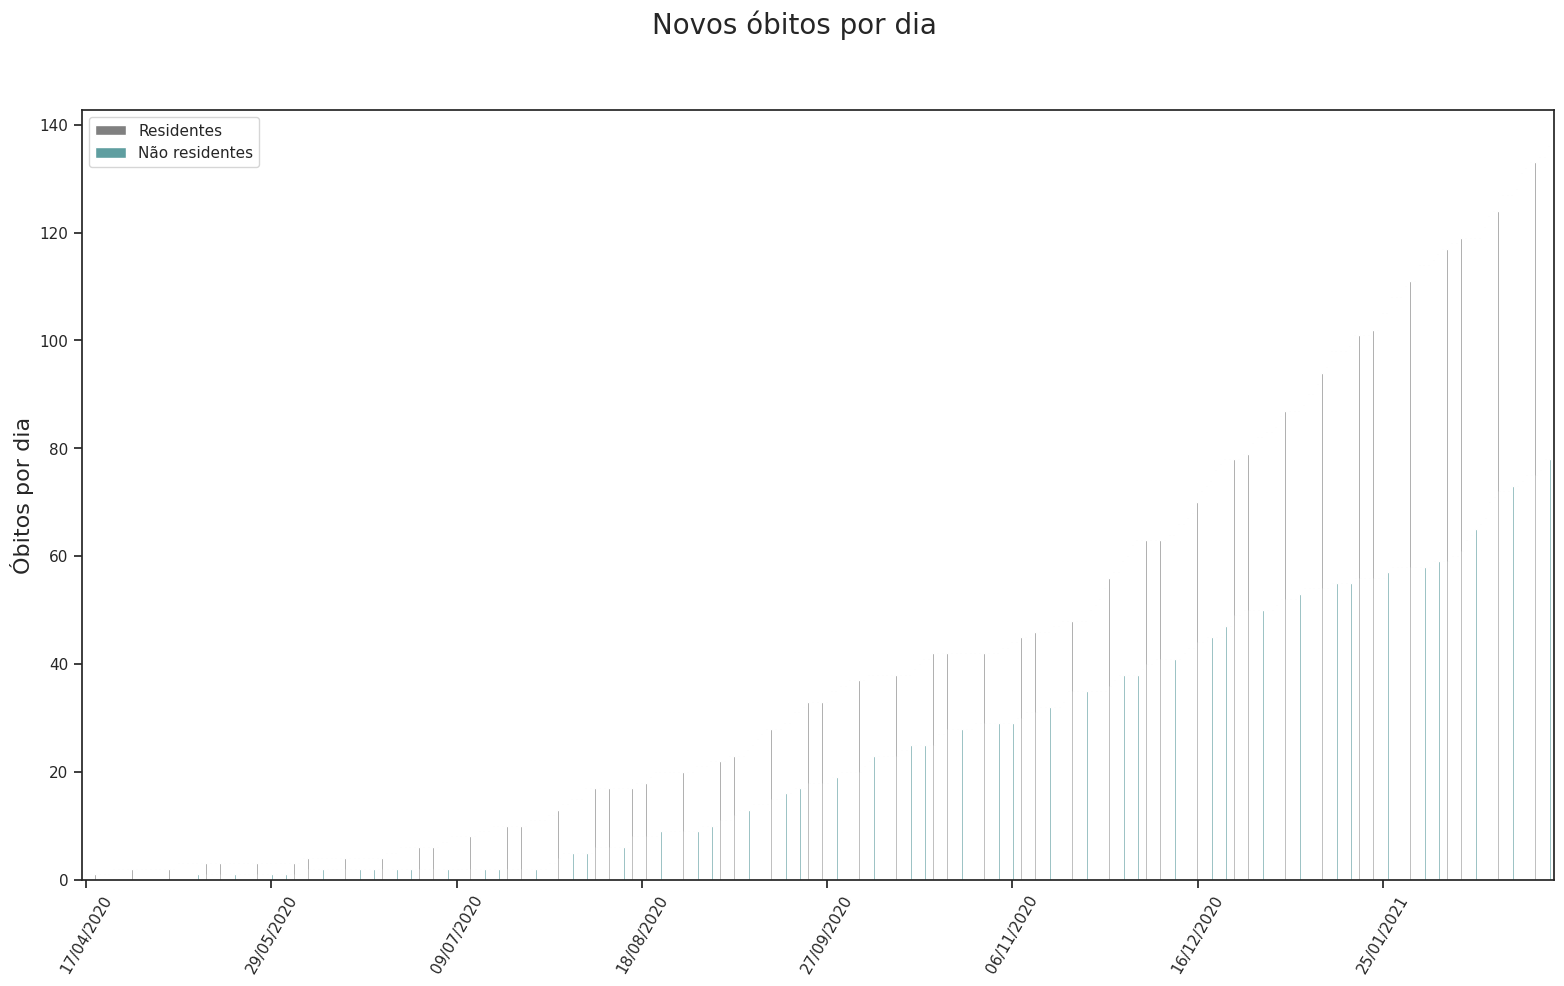

In [15]:
dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_amostra = """
                SELECT `data`, (obitos_confirmados - obitos_nao_residentes) as obitos_residentes, obitos_nao_residentes, eventos
                FROM boletins
                ORDER BY data ASC
                """

cursor.execute(sql_amostra)

df_novos = pd.read_sql(sql_amostra, conn)

df_novos['data'] = pd.to_datetime(df_novos['data'], format='%Y-%m-%d')
df_novos["data"] = df_novos["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

x = df_novos.reset_index()['index']

graf = df_novos.plot.bar(figsize=(19, 10), legend=False, color=['gray','cadetblue'])

plt.xticks(df_novos.index, df_novos["data"].values, rotation=60)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.suptitle('Novos óbitos por dia', fontsize=20)

plt.ylabel('Óbitos por dia', fontsize=16)

labels = list(df_novos['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_fn))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend(['Residentes', 'Não residentes'])

# limites eixos x e y
plt.ylim(0, None)
plt.xlim(-1, max(x)+1)

plt.show()

conn.close()

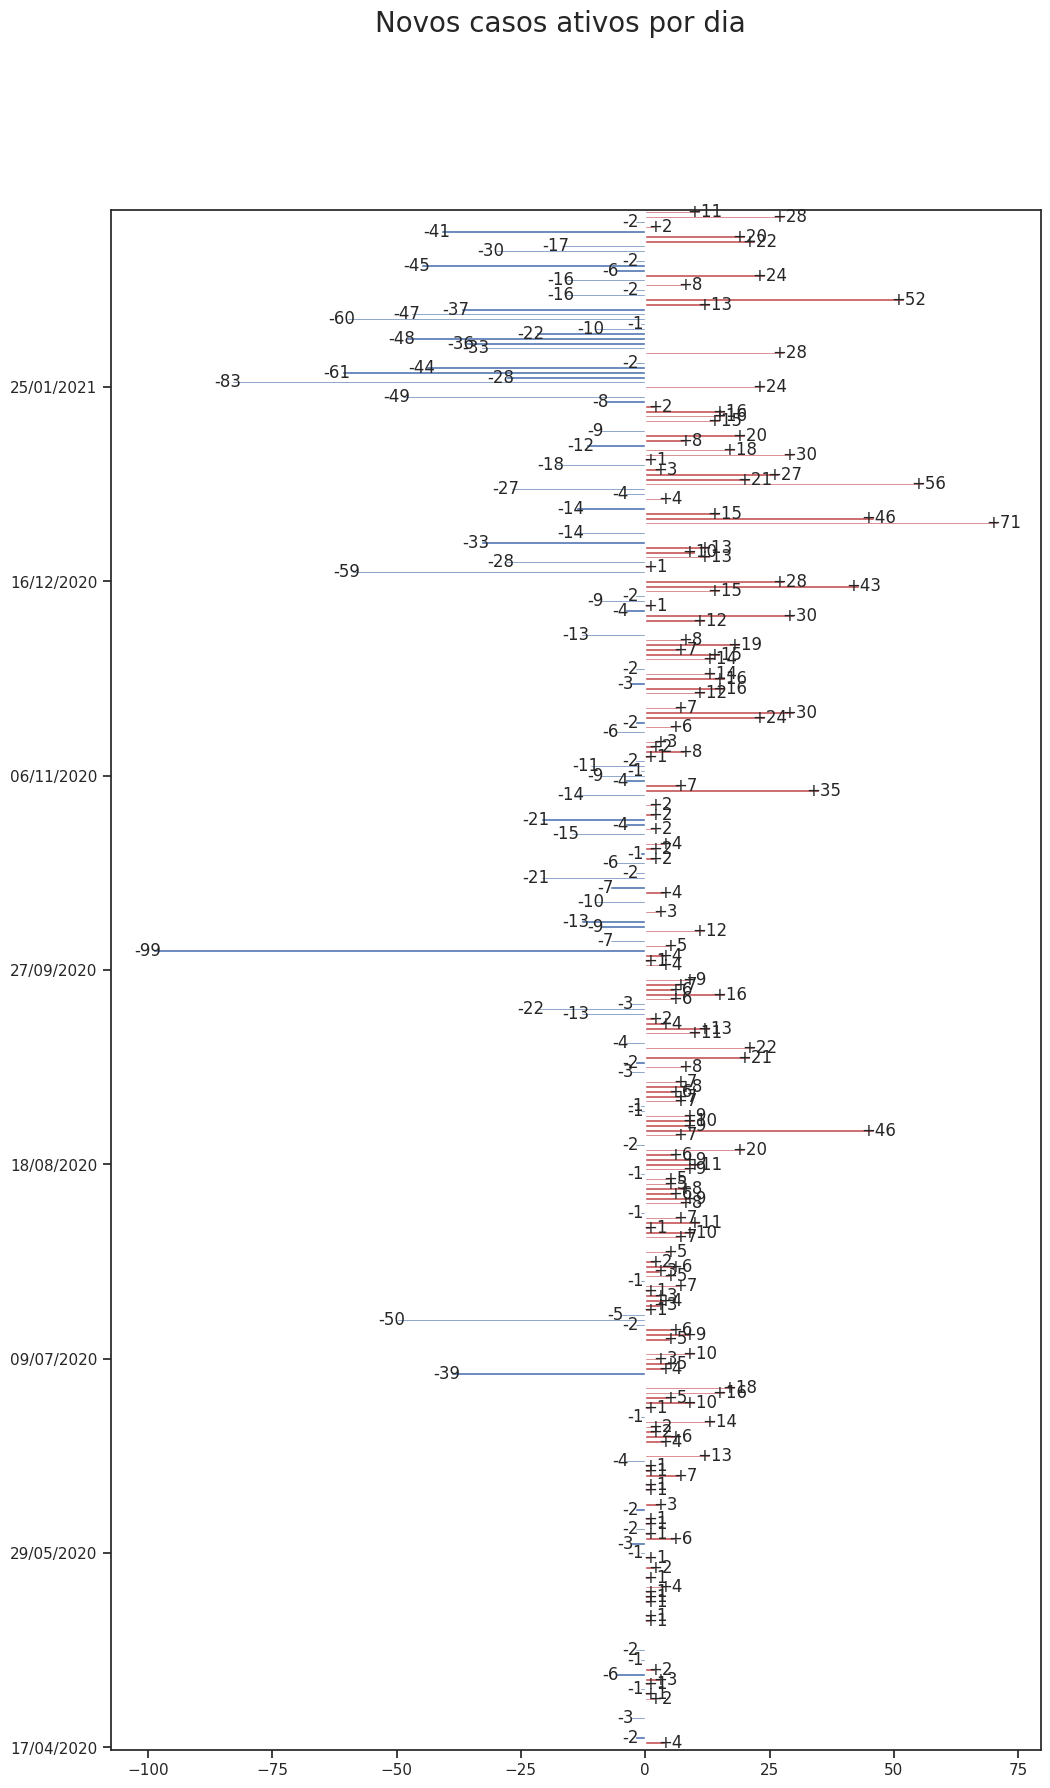

In [16]:
import math

dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_amostra = """
                SELECT id, `data`
                 , COALESCE((confirmados_isolamento + confirmados_ala + confirmados_uti) - @prev,0) AS novos_ativos
                 , @prev:=(confirmados_isolamento + confirmados_ala + confirmados_uti) 
                FROM boletins
                 , (SELECT @prev:=null) vars 
                ORDER 
                    BY `data`;
                """

cursor.execute(sql_amostra)

df_novos = pd.read_sql(sql_amostra, conn)

df_novos['data'] = pd.to_datetime(df_novos['data'], format='%Y-%m-%d')
df_novos["data"] = df_novos["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

x = df_novos.reset_index()['index']

graf = df_novos['novos_ativos'].plot(figsize=(12, 20), kind='barh',
                    color=(df_novos['novos_ativos'] > 0).map({True: 'r',
                                                    False: 'b'}))


plt.suptitle('Novos casos ativos por dia', fontsize=20)

plt.yticks(df_novos.index, df_novos["data"].values, rotation=0)

labels = list(df_novos['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_fn))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

for i, label in enumerate(list(df_novos['novos_ativos'])):
    height = int(label)
    if label > 0:
        plt.annotate('+'+str(label), (height+1, i), ha="center", va="center")
    if label < 0:
        plt.annotate(str(label), (height-1, i), ha="center", va="center")

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

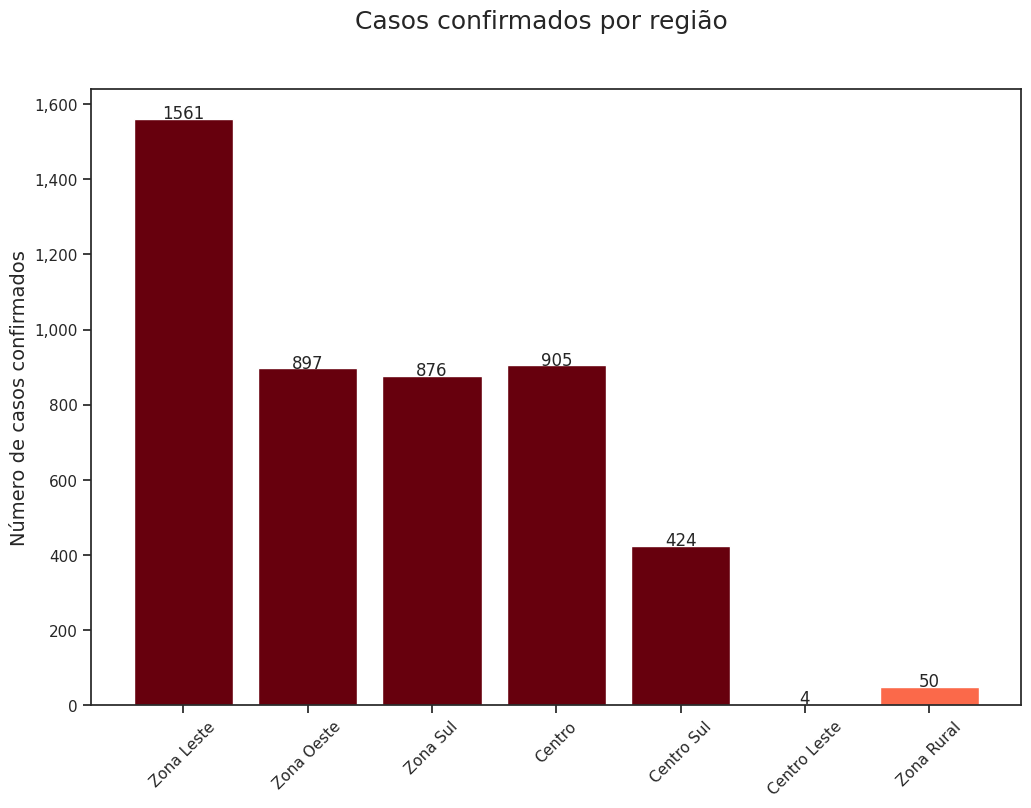

In [17]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
from itertools import cycle, islice
from matplotlib.colors import Normalize

dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_zonas = """
            SELECT "Zona Leste" AS regiao, MAX(z_leste) AS casos FROM boletins UNION                         
            SELECT "Zona Oeste" AS regiao, MAX(z_oeste) AS casos FROM boletins UNION
            SELECT "Zona Sul" AS regiao, MAX(z_sul) AS casos FROM boletins UNION
            SELECT "Centro" AS regiao, MAX(z_centro) AS casos FROM boletins UNION
            SELECT "Centro Sul" AS regiao, MAX(z_centrosul) AS casos FROM boletins UNION
            SELECT "Centro Leste" AS regiao, MAX(z_centroleste) AS casos FROM boletins UNION
            SELECT "Zona Rural" AS regiao, MAX(z_rural) AS casos FROM boletins
                """

df_zonas = pd.read_sql(sql_zonas, conn)

data = df_zonas['casos']
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

x = df_zonas.reset_index()['index']

# Obtém mapa de cores
my_cmap = cm.get_cmap('Reds')
 
my_norm = Normalize(vmin=0, vmax=100)

graf = ax.bar(df_zonas['regiao'], df_zonas['casos'], color=my_cmap(my_norm(data)))

plt.xticks(df_zonas.index, df_zonas['regiao'].values, rotation=45)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

plt.suptitle('Casos confirmados por região', fontsize=18)

plt.ylabel('Número de casos confirmados', fontsize=14)

for i, valor in enumerate(df_zonas['casos']):
    plt.annotate(valor, (x[i],df_zonas['casos'].values[i]+1), ha='center')

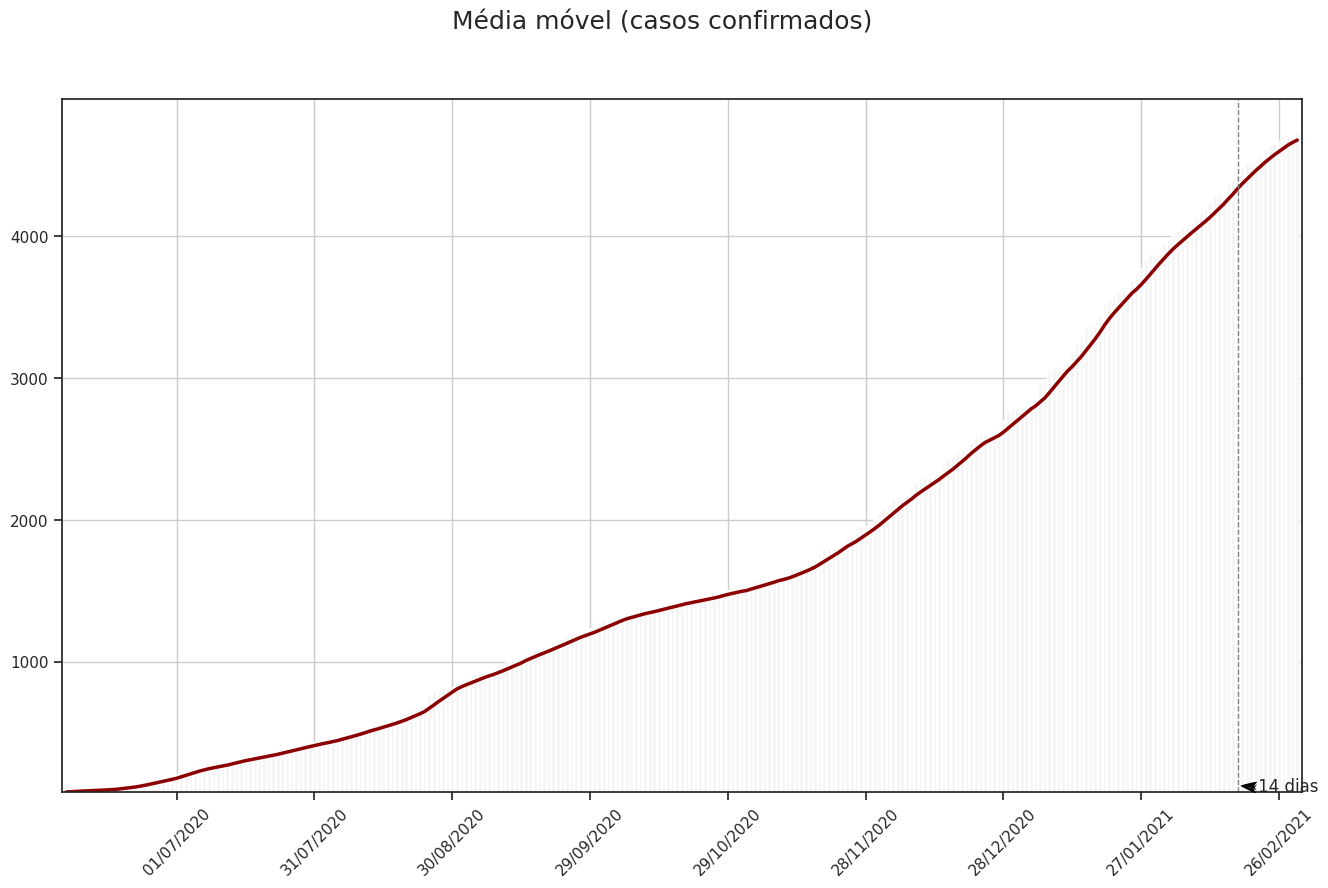

In [18]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
from itertools import cycle, islice
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator

dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_mediamovel =   """
                select t1.`data`, t1.casos_confirmados, if(count(1)>=7,avg(t2.casos_confirmados),NULL) AS mediamovel 
                from boletins t1 , boletins t2
                where t2.`data` between DATE_SUB(date(t1.`data`),INTERVAL 6 day)+0 and t1.`data` AND t1.`data` >= "2020-06-01"
                group by t1.`data`, t1.casos_confirmados
                order BY t1.`data`
                """

cursor.execute(sql_mediamovel)

df = pd.read_sql(sql_mediamovel, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_mediamovel = df.copy()

fig, ax = plt.subplots(figsize=(16, 9))

plt.xticks(df_mediamovel.index, df_mediamovel["data"].values, rotation=45)

x = df_mediamovel.reset_index()['index']
y = df_mediamovel['mediamovel']

ax.plot(y, color='darkred', linewidth=2.5)

x2 = df_mediamovel.reset_index()['index']
y2 = df_mediamovel['casos_confirmados']

ax.bar(x2, y2, color='whitesmoke')

plt.suptitle('Média móvel (casos confirmados)', fontsize=18)

# limites eixos x e y
plt.ylim(80, None)
plt.xlim(5,max(x)+1)

labels = list(df_mediamovel['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.annotate('- 14 dias', xy=(x[len(df_mediamovel)-14],130), xytext=(x[len(df_mediamovel)-14]+2,120), 
                     arrowprops=dict(arrowstyle="fancy, head_width=0.7, head_length=1",
                            fc="0", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-45"), fontsize=12, va='center')

posicao = x[len(df_mediamovel)-14]

plt.axvline(x=posicao, color='gray', linestyle='--', linewidth=1)

plt.grid()

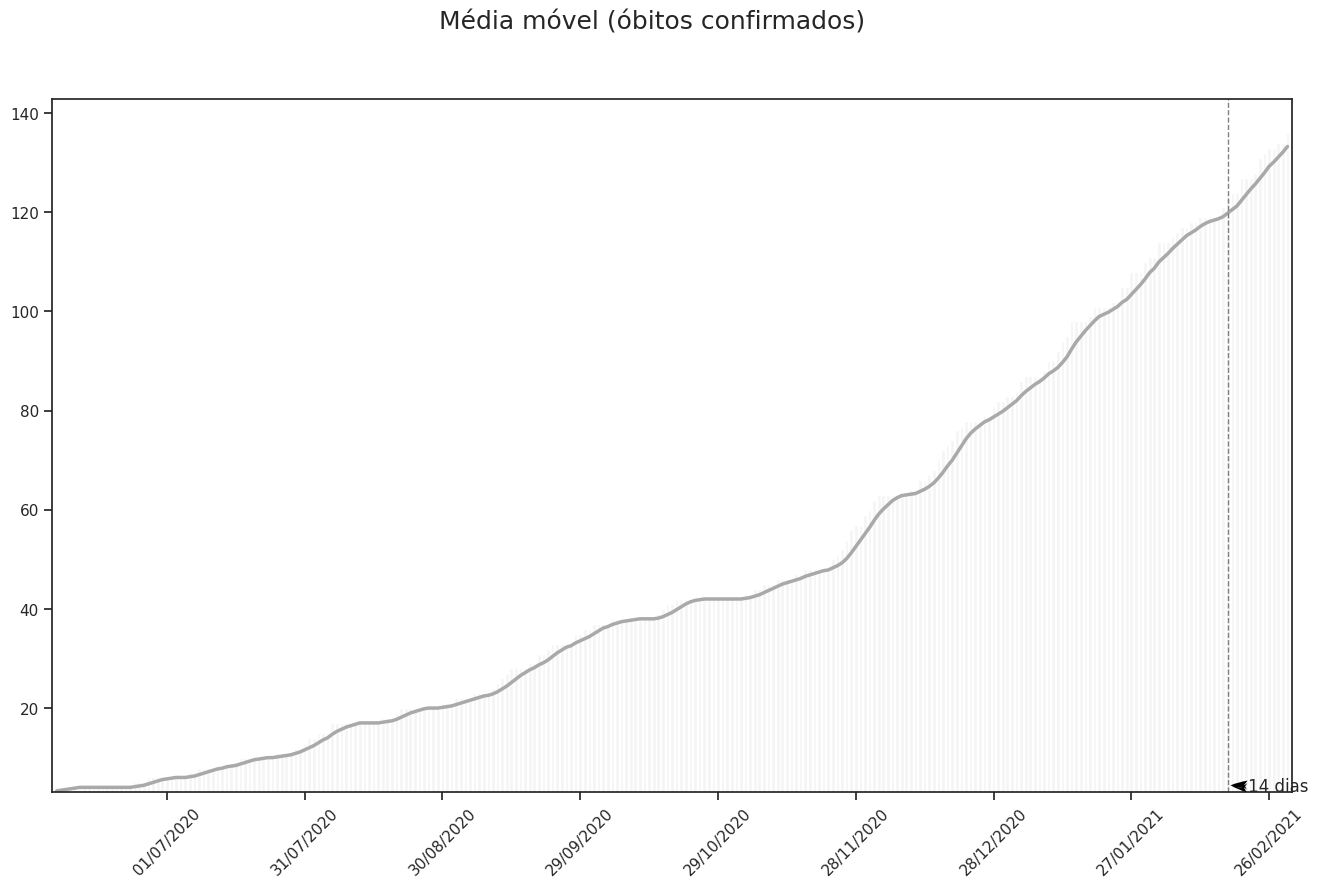

In [19]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
from itertools import cycle, islice
from matplotlib.colors import Normalize

dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_mediamovel =   """
                select t1.`data`, t1.obitos_residentes, if(count(1)>=7,avg(t2.obitos_residentes),NULL) AS mediamovel 
                from boletins t1 , boletins t2
                where t2.`data` between DATE_SUB(date(t1.`data`),INTERVAL 6 day)+0 and t1.`data` AND t1.`data` >= "2020-06-01"
                group by t1.`data`, t1.obitos_residentes
                order BY `data` ASC
                """

cursor.execute(sql_mediamovel)

df = pd.read_sql(sql_mediamovel, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_mediamovel = df.copy()

fig, ax = plt.subplots(figsize=(16, 9))

plt.xticks(df_mediamovel.index, df_mediamovel["data"].values, rotation=45)

x = df_mediamovel.reset_index()['index']
y = df_mediamovel['mediamovel']

ax.plot(y, color='darkgray', linewidth=2.5)

x2 = df_mediamovel.reset_index()['index']
y2 = df_mediamovel['obitos_residentes']

ax.bar(x2, y2, color='whitesmoke')

plt.suptitle('Média móvel (óbitos confirmados)', fontsize=18)

# limites eixos x e y
plt.ylim(3, None)
plt.xlim(5,max(x)+1)

labels = list(df_mediamovel['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


plt.annotate('- 14 dias', xy=(x[len(df_mediamovel)-14],4.5), xytext=(x[len(df_mediamovel)-14]+2,4.3), 
                     arrowprops=dict(arrowstyle="fancy, head_width=0.7, head_length=1",
                            fc="0", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-45"), fontsize=12, va='center')

posicao = x[len(df_mediamovel)-14]

plt.axvline(x=posicao, color='gray', linestyle='--', linewidth=1)

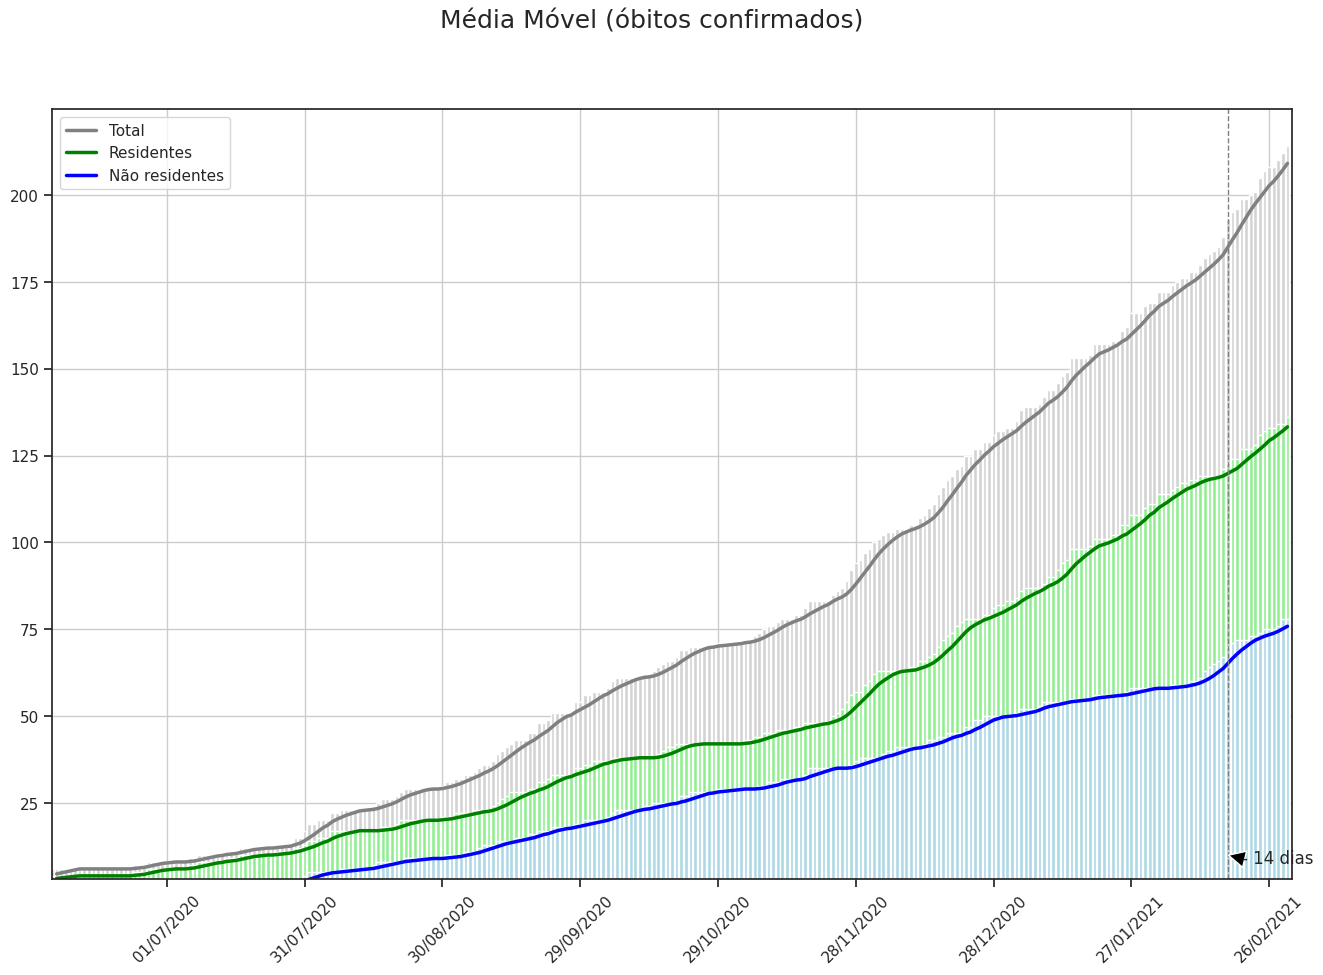

In [20]:
dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_mediamovel =   """
                select t1.`data`, t1.obitos_confirmados, t1.obitos_residentes, t1.obitos_nao_residentes,
                    if(count(1)>=7,avg(t2.obitos_residentes),NULL) AS mediamovel_res, 
                    if(count(1)>=7,avg(t2.obitos_nao_residentes),NULL) AS mediamovel_nres,
                    if(count(1)>=7,avg(t2.obitos_confirmados),NULL) AS mediamovel
                from boletins t1 , boletins t2
                where t2.`data` between DATE_SUB(date(t1.`data`),INTERVAL 6 day)+0 and t1.`data` AND t1.`data` >= "2020-06-01"
                group by t1.`data`, t1.obitos_residentes, t1.obitos_nao_residentes, t1.obitos_confirmados
                order BY t1.`data`
                """

cursor.execute(sql_mediamovel)

df = pd.read_sql(sql_mediamovel, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_mediamovel = df.copy()

fig, ax = plt.subplots(figsize=(16, 10))

plt.xticks(df_mediamovel.index, df_mediamovel["data"].values, rotation=45)

x = df_mediamovel.reset_index()['index']
y = df_mediamovel['mediamovel']

ax.plot(y, color='gray', linewidth=2.5)

x2 = df_mediamovel.reset_index()['index']
y2 = df_mediamovel['mediamovel_res']

ax.plot(y2, color='green', linewidth=2.5)

x3 = df_mediamovel.reset_index()['index']
y3 = df_mediamovel['mediamovel_nres']

ax.plot(y3, color='blue', linewidth=2.5)

x4 = df_mediamovel.reset_index()['index']

y4 = df_mediamovel['obitos_confirmados']

y5 = df_mediamovel['obitos_residentes']

y6 = df_mediamovel['obitos_nao_residentes']


ax.bar(x4, y4, color='lightgray')
ax.bar(x4, y5, color='lightgreen')
ax.bar(x4, y6, color='lightblue')

plt.suptitle('Média Móvel (óbitos confirmados)', fontsize=18)

# limites eixos x e y
plt.ylim(3, None)
plt.xlim(5,max(x)+1)

labels = list(df_mediamovel['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.annotate('- 14 dias', xy=(x[len(df_mediamovel)-14],10), xytext=(x[len(df_mediamovel)-14]+3,9), 
                     arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, va='center')

posicao = x[len(df_mediamovel)-14]
    
plt.axvline(x=posicao, color='gray', linestyle='--', linewidth=1)

plt.grid()

plt.legend(['Total','Residentes', 'Não residentes'])

conn.close()

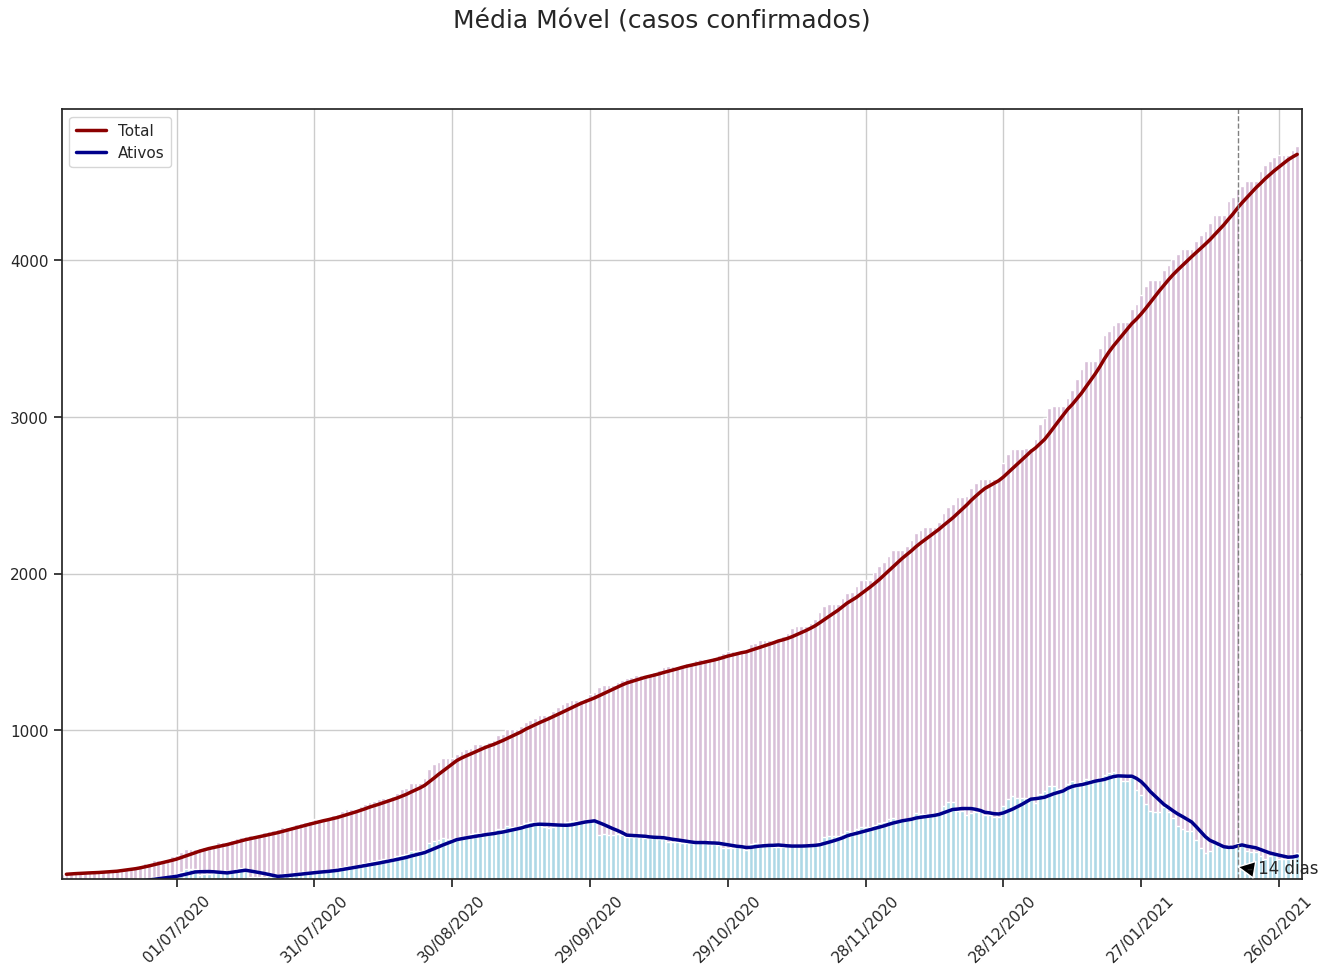

In [21]:
dados_conn = open('conn.txt', 'r', encoding='utf-8')

conn = eval('pymysql.connect({})'.format(dados_conn.readline().strip()))

dados_conn.close()

cursor = conn.cursor()

sql_mediamovel =   """
                select t1.`data`, t1.casos_confirmados, 
                (t1.confirmados_isolamento + t1.confirmados_ala + t1.confirmados_uti) as ativos,
                if(count(1)>=7,avg(t2.casos_confirmados),NULL) AS mediamovel,
                if(count(1)>=7,avg(t2.confirmados_isolamento + t2.confirmados_ala + t2.confirmados_uti),NULL) AS mediamovel_ativos
                from boletins t1 , boletins t2
                where t2.`data` between DATE_SUB(date(t1.`data`),INTERVAL 6 day)+0 and t1.`data` AND t1.`data` >= "2020-06-01"
                group by t1.`data`, t1.casos_confirmados, ativos
                order BY t1.`data`
                """

cursor.execute(sql_mediamovel)

df = pd.read_sql(sql_mediamovel, conn)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df["data"] = df["data"].map(lambda ts: ts.strftime("%d/%m/%Y"))

df_mediamovel = df.copy()

fig, ax = plt.subplots(figsize=(16, 10))

plt.xticks(df_mediamovel.index, df_mediamovel["data"].values, rotation=45)

x = df_mediamovel.reset_index()['index']
y = df_mediamovel['mediamovel']

ax.plot(y, color='darkred', linewidth=2.5)

y2 = df_mediamovel['mediamovel_ativos']

ax.plot(y2, color='darkblue', linewidth=2.5)

x3 = df_mediamovel.reset_index()['index']
y3 = df_mediamovel['casos_confirmados']

x4 = df_mediamovel.reset_index()['index']
y4 = df_mediamovel['ativos']

ax.bar(x3, y3, color='thistle')
ax.bar(x4, y4, color='lightblue')

plt.suptitle('Média Móvel (casos confirmados)', fontsize=18)


# limites eixos x e y
plt.ylim(50, None)
plt.xlim(5,max(x)+1)

labels = list(df_mediamovel['data'])

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.annotate('- 14 dias', xy=(x[len(df_mediamovel)-14],130), xytext=(x[len(df_mediamovel)-14]+2,120), 
                     arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, va='center')

posicao = x[len(df_mediamovel)-14]

plt.axvline(x=posicao, color='gray', linestyle='--', linewidth=1)

plt.grid()

ax.legend(['Total','Ativos'])

conn.close()